In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, f1_score, average_precision_score,make_scorer,classification_report
from sklearn.utils import compute_sample_weight
import optuna
import requests
import os
import networkx as nx
from xgboost import XGBClassifier
import igraph as ig
import sys


In [2]:
#loead data 
data = pd.read_csv("/Users/alixvanhees/Documents/HIRB THESIS /HI-Small_Trans_subset.csv") 
data.tail()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
2999995,2022/09/07 11:00,410,800240B70,10,80005B110,14402.14,US Dollar,14402.14,US Dollar,ACH,1
2999996,2022/09/08 19:26,232073,80BA3FAD0,221279,80BA3FB70,2560.23,Euro,2560.23,Euro,ACH,1
2999997,2022/09/09 15:08,23289,808839F70,24840,80A2A61B0,12320.70,Euro,12320.70,Euro,ACH,1
2999998,2022/09/03 22:42,23538,80D018930,222363,80D018D90,37314.94,US Dollar,37314.94,US Dollar,ACH,1
2999999,2022/09/01 20:30,113,80FFF5A30,243897,80FFF5B20,4027.43,Shekel,4027.43,Shekel,ACH,1


In [3]:
# timefeatures
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['Hour'] = data['Timestamp'].dt.hour
data['Date_Year'] = data['Timestamp'].dt.year
data['Date_Month'] = data['Timestamp'].dt.month
data['Date_Day'] = data['Timestamp'].dt.day

data.drop(columns=['Timestamp'], inplace=True)

#combine Amount Paid and Amount Received 
data['Amount'] = data[['Amount Paid', 'Amount Received']].mean(axis=1)  



In [4]:
categorical_cols = [
    'Account', 'Account.1',
    'From Bank', 'To Bank',
    'Payment Format'  
]

for col in categorical_cols:
    data[col] = data[col].fillna("missing").astype(str)

data.dropna(subset=['Account', 'Account.1', 'Amount'], inplace=True)

# Network and time features
G = nx.DiGraph()
edges = list(zip(data["Account"], data["Account.1"], data["Amount"]))
G.add_weighted_edges_from(edges)

G_ig = ig.Graph.TupleList(edges, directed=True)
data["degree_centrality"] = data["Account"].map(dict(zip(G_ig.vs["name"], G_ig.degree()))).fillna(0)
pagerank_scores = G_ig.pagerank()
data["pagerank"] = data["Account"].map(dict(zip(G_ig.vs["name"], pagerank_scores))).fillna(0)

# time and transactional features
window_size = 50
data["rolling_24h_amount"] = data.groupby("Account")["Amount"]\
                                 .rolling(window_size).sum().reset_index(0, drop=True).fillna(0)
data["transaction_count"] = data.groupby("Account")["Amount"].transform("count")

features = data.drop(columns=[
    'Is Laundering',
    'Payment Currency',
    'Receiving Currency',
    'rolling_24h_amount'  
]).copy()

# add the extra features
features["degree_centrality"] = data["degree_centrality"]
features["pagerank"] = data["pagerank"]
features["rolling_24h_amount"] = data["rolling_24h_amount"]
features["transaction_count"] = data["transaction_count"]

# remove irrelevant features
features.drop(columns=['Date_Year', 'Date_Month'], inplace=True, errors='ignore')

# Target
target = data['Is Laundering']
data_standardized = features.copy()
data_standardized['Is Laundering'] = target.reset_index(drop=True)

In [5]:
# Split data 
X = data_standardized.drop(columns=["Is Laundering"])
y = data_standardized["Is Laundering"]

# Train/test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Train/validation split within the trainingset
X_train, X_val, y_train_true, y_val_true = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

#label encoding
encoders = {}
for col in categorical_cols:
    combined = pd.concat([X_train[col], X_val[col], X_test[col]]).astype(str)
    le = LabelEncoder().fit(combined)
    
    X_train[col] = le.transform(X_train[col].astype(str))
    X_val[col] = le.transform(X_val[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    
    encoders[col] = le

#scaling
numerical_cols = ['Hour', 'Date_Day', 'Amount']
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


sample_weights = compute_sample_weight(class_weight={0: 1, 1: 10}, y=y_train_true)

In [6]:
def maak_pu_setting_van_echte_labels(y_true, label_ratio, random_state=42):
    """
    Maakt PU-labels op basis van bestaande echte labels in y_true.
    Alleen een percentage van de positieven wordt als gelabeld behouden.
    """
    np.random.seed(random_state)

    # take only true positives
    positieve_indexen = np.where(y_true == 1)[0]
    n_gelabeld = int(label_ratio * len(positieve_indexen))
    gelabelde_indexen = np.random.choice(positieve_indexen, size=n_gelabeld, replace=False)

    y_pu = np.zeros_like(y_true)
    y_pu[gelabelde_indexen] = 1

    return y_pu, y_true, gelabelde_indexen


alpha = 0.001  # 0.1% prior from the full dataset 
label_ratio = 0.2  # 20% labeling probability (c)

y_train_pu, y_train_true, gelabelde_indexen = maak_pu_setting_van_echte_labels(y_train_true, label_ratio)


In [7]:
#BEST parameter: Beste parameters: {'C': 0.014610103447595585}
# Train with beste model
best_model = LogisticRegression(
    C= 0.014610103447595585,
    penalty='l2',
    solver='lbfgs',
    class_weight='balanced',
    max_iter=1000
)
best_model.fit(X_train, y_train_pu)

LogisticRegression(C=0.014610103447595585, class_weight='balanced',
                   max_iter=1000)

In [8]:
y_probs = best_model.predict_proba(X_test)[:, 1]  

# List of thresholds from 0.0 tot 1.0 in steps of 0.05
thresholds = np.arange(0.0, 1.05, 0.05)

# F1-scores en PR AUC scores for different thresholds 
best_threshold = 0
best_f1 = 0
f1_scores = []
pr_auc_scores = []

for threshold in thresholds:
    y_pred_custom = (y_probs >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_custom)
    pr_auc = average_precision_score(y_test, y_pred_custom)
    f1_scores.append(f1)
    pr_auc_scores.append(pr_auc)
    
    # checker whether this threshold is better than previous best
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold


Beste threshold: 0.56
Accuracy: 0.95226
Precision: 0.005387347966217329
Recall: 0.24972737186477645
F1-score: 0.010547162859248343
ROC AUC: 0.6417713139930356
PR AUC (beste threshold): 0.0024310387476461095


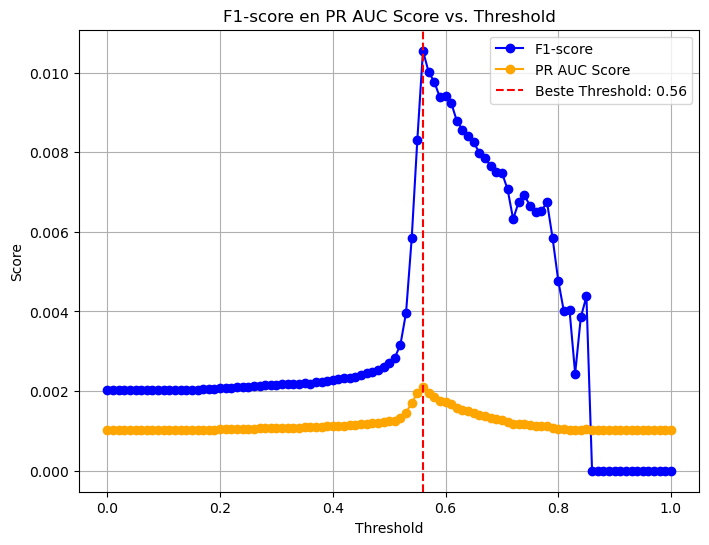

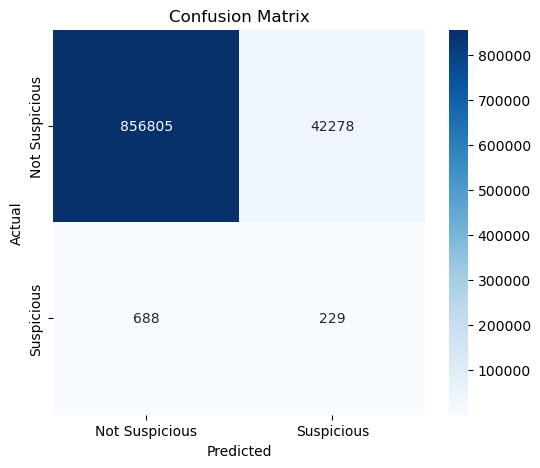

In [9]:
y_probs = best_model.predict_proba(X_test)[:, 1]
thresholds = np.linspace(0.0, 1.0, 101)
f1_scores = [f1_score(y_test, (y_probs >= t).astype(int)) for t in thresholds]
pr_auc_scores = [average_precision_score(y_test, (y_probs >= t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
y_pred_best = (y_probs >= best_threshold).astype(int)


# evalution with best threshold
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_probs)
pr_auc_best = average_precision_score(y_test, y_probs)

# results
print(f"Beste threshold: {best_threshold}")
print(f"Accuracy: {accuracy_best}")
print(f"Precision: {precision_best}")
print(f"Recall: {recall_best}")
print(f"F1-score: {f1_best}")
print(f"ROC AUC: {roc_auc_best}")
print(f"PR AUC (beste threshold): {pr_auc_best}")

# Plotting F1-score and  PR AUC versus Thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, marker='o', linestyle='-', label="F1-score", color='blue')
plt.plot(thresholds, pr_auc_scores, marker='o', linestyle='-', label="PR AUC Score", color='orange')
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Beste Threshold: {best_threshold:.2f}')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("F1-score en PR AUC Score vs. Threshold")
plt.legend()
plt.grid(True)
plt.show()


# Confusion matrix 
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Blues', xticklabels=['Not Suspicious', 'Suspicious'], yticklabels=['Not Suspicious', 'Suspicious'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [16]:
#optuna 
def objective(trial):
    C = trial.suggest_float("C", 0.01, 100.0, log=True)

    model = LogisticRegression(
        C=C,
        penalty='l2',
        solver='lbfgs',
        class_weight='balanced',
        max_iter=1000
    )

    # Train on PU-labels
    model.fit(X_train, y_train_pu)


    y_val_pred = model.predict(X_val)

    score = f1_score(y_val_true, y_val_pred)

    return score


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, timeout=300)

print("Beste parameters:", study.best_params)
print("Beste F1-score (CV):", study.best_value)


[I 2025-05-12 11:00:07,517] A new study created in memory with name: no-name-4c3ec01a-d3dd-4109-8ee6-25ae43b902ee
[I 2025-05-12 11:00:28,435] Trial 0 finished with value: 0.0027462286542064007 and parameters: {'C': 0.334337087410736}. Best is trial 0 with value: 0.0027462286542064007.
[I 2025-05-12 11:00:48,245] Trial 1 finished with value: 0.0027461897796442225 and parameters: {'C': 8.45811224024159}. Best is trial 0 with value: 0.0027462286542064007.
[I 2025-05-12 11:01:09,791] Trial 2 finished with value: 0.002746773013663072 and parameters: {'C': 0.014610103447595585}. Best is trial 2 with value: 0.002746773013663072.
[I 2025-05-12 11:01:30,931] Trial 3 finished with value: 0.0027465656131872903 and parameters: {'C': 0.3241989400455482}. Best is trial 2 with value: 0.002746773013663072.
[I 2025-05-12 11:01:50,999] Trial 4 finished with value: 0.0027462416126383736 and parameters: {'C': 1.114917664342499}. Best is trial 2 with value: 0.002746773013663072.
[I 2025-05-12 11:02:13,675]

Beste parameters: {'C': 0.014610103447595585}
Beste F1-score (CV): 0.002746773013663072


NameError: name 'X_train_scaled' is not defined

In [31]:
np.save("logreg_IBM_y_true.npy",y_test)
np.save("logreg_IBM_y_pred.npy",y_pred_best)
np.save("logreg_IBM_y_probs.npy",y_probs)
